In [440]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from keras.regularizers import l2
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, classification_report
from keras.callbacks import ModelCheckpoint

In [807]:
###Load dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [808]:
###Eliminate empty string values in totals column
string_bool = df['TotalCharges'] > " "
df = df[string_bool]

In [809]:
###Seperate labels/features
#df_labels = pd.get_dummies(df['Churn']) ##For categorical_crossentropy
df_labels = df['Churn']
df_features = df.drop(['Churn', 'customerID'], axis = 1)

In [810]:
###Check dataset
df_features.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


In [811]:
###Make gender binary
df_features['gender'] = df_features['gender'].apply(lambda x: 1 if x == 'Female' else 0)

In [812]:
###Make yes/no features binary
yes_no_features = ['Partner', 'Dependents', 'PhoneService', 'OnlineSecurity',
                   'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'PaperlessBilling',
                  'StreamingMovies']
for i in yes_no_features:
    df_features[i] = df_features[i].apply(lambda x: 1 if x == 'Yes' else 0)

In [813]:
###Make categorical features binary
categorical_features = ['MultipleLines', 'InternetService', 'Contract', 'PaymentMethod']
for i in categorical_features:
    df_features = pd.get_dummies(df_features, columns = [i])

In [814]:
###Check dataset
df_features.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,1,0,0,...,1,0,0,1,0,0,0,0,1,0
1,0,0,0,0,34,1,1,0,1,0,...,1,0,0,0,1,0,0,0,0,1
2,0,0,0,0,2,1,1,1,0,0,...,1,0,0,1,0,0,0,0,0,1
3,0,0,0,0,45,0,1,0,1,1,...,1,0,0,0,1,0,1,0,0,0
4,1,0,0,0,2,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


In [815]:
###Make labels binary
df_labels = df_labels.apply(lambda x: 0 if x == 'No' else 1)#(lambda x : 'No' if x == 0 else 'Yes')

In [822]:
###Scale data between .05 and .95 (I dont like zeros)
scaler = MinMaxScaler(feature_range = (.05, .95))
scaled_df = scaler.fit_transform(df_features)

In [823]:
###Change df to array
X = np.array(scaled_df)
Y = np.array(df_labels)

In [824]:
###Test train split
split_num = int(len(X) * 0.8)

x_train, x_test = X[:split_num], X[split_num:]
y_train, y_test = Y[:split_num], Y[split_num:]

In [825]:
###Instantiate model
input_shape = x_train.shape[1]
y_train = y_train.reshape(5625,1)

model = Sequential()
model.add(Dense(32, input_shape = (input_shape,), activation = 'relu', activity_regularizer = l2(0.001),
               kernel_initializer = 'truncated_normal'))
model.add(Dropout(.4))
model.add(Dense(64, activation = 'relu', activity_regularizer = l2(0.001), kernel_initializer = 'truncated_normal'))
model.add(Dense(64, activation = 'relu', activity_regularizer = l2(0.001), kernel_initializer = 'truncated_normal'))
model.add(Dense(1, activation = 'sigmoid'))

In [826]:
###Create checkpoint
callbacks = ModelCheckpoint(filepath = 'churn_weights1.hdf5', monitor = 'val_loss', save_best_only = True)

In [827]:
###Compile model
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc'] )

In [759]:
###Fit Model
history = model.fit(x_train, y_train, batch_size = 32, epochs = 500, validation_split = 0.1, verbose = 0, callbacks = [callbacks])

In [829]:
###Load best weights
model.load_weights('churn_weights.hdf5')

In [830]:
###Check accuracy
score = model.evaluate(x_test, y_test)
score

1407/1407 [==============================] - 0s 66us/step


[0.44554089368787658, 0.80099502428254088]

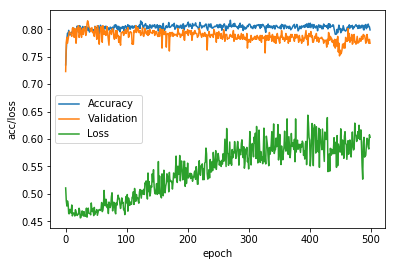

0.816278150905


In [831]:
###Plot acc, val acc, and loss
plt.plot(history.history['acc'], label = 'Accuracy')
plt.plot(history.history['val_acc'], label = 'Validation')
plt.plot(history.history['val_loss'], label = 'Loss')
plt.xlabel('epoch')
plt.ylabel('acc/loss')
plt.legend()
plt.show()
print(np.max(history.history['acc']))

In [832]:
###Make predictions and create threshold
preds = model.predict(x_test)
y_pred = (preds > 0.25).astype('int')

In [833]:
###Confusion matrix
cf = confusion_matrix(y_test, y_pred)
cf

array([[675, 351],
       [ 61, 320]])

In [834]:
###Accuracy score after threshold
acc = accuracy_score(y_test, y_pred)
acc

0.70717839374555791

In [835]:
###Classification report after threshold
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.92      0.66      0.77      1026
          1       0.48      0.84      0.61       381

avg / total       0.80      0.71      0.72      1407

